## Wrangle Act Part 2: Data Analysis
After cleaning and storing the data into two CSV-sources I will try now to draw several conclusions from the datasets. Before doing so I will import the necessary python modules and read the data sources into DataFrames.
### Environment Preperation

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [4]:
tam_df = pd.read_csv('twitter_archive_master.csv',sep=',')
tip_df = pd.read_csv('twitter_image_prediction.csv',sep=',')

In [5]:
tip_df.head(1)

,tweet_id,jpg_url,p1,p1_conf,p1_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True


In [6]:
tam_df.head(1)

,tweet_id,timestamp,text,name,dogtype,rating,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,Phineas,none,1.3,8281,37925


### First Insight: Correlation of dog rating and Retweet Count/Favourite Count
#### Assumption
My first insight will examine the correlation between the __Rating__ and the __retweet_count__ and __favourite_count__. My obvious assumption is that dogs with higher ratings will have higher amounts of retweets and favorite markings. I will utilize the pandas __corr__ function to correlate every column with each other:

#### Code

In [63]:
tam_df.corr()

,tweet_id,rating,retweet_count,favorite_count
tweet_id,1.000000,0.047361,0.379280,0.508291
rating,0.047361,1.000000,0.013992,0.014403
retweet_count,0.379280,0.013992,1.000000,0.798627
favorite_count,0.508291,0.014403,0.798627,1.000000


#### Evaluation

The only strong correlation with a practical relevance can be observated between the __retweet_count__ and the __favorite_count__. That means a dog tweet that will be often retweeted will also be often favorised. I guess this correlation is reasonable. Unfortunately there is a almost non-existent correlation between __retweet_count__ and the rating.

### Second Insight: High Confidence in Image Classification for "Dogtionary" labeled dogs
#### Assumption
Now I will try to verify my assumption, that dogs that got a label from "WeRateDogs" like __"doggo"__ should have a very high level of mean confidence compared to the entries without a label. 
I have this assumption, because I believe that a dog that can be labeled according to the "WeRateDogs Dogtionary", should have a very typical dog appearance and thus can be classified by a estimator with a high confidence.

#### Code
Mean over all confidence levels of estimated dog pictures:

In [8]:
tip_df.p1_conf.mean()

0.59454826361445778

In [9]:
1*tip_df.p1_dog.sum()

1532

Mean over confidence level with a label from "WeRateDogs":

In [10]:
dogs_with_label = list(tam_df[tam_df.dogtype != 'none'].tweet_id)
tip_df[tip_df['tweet_id'].isin(dogs_with_label)]['p1_conf'].mean()

0.61019812106824922

#### Evaluation
There is only a slightly increase of the mean confidence for the dogs that got a label according to the "WeRateDogs Dogtionary". For me this isn't a evidence for a better estimation confidence for dogs with a classification label.

### Third Insight and Visualisation: Increase of Social Media Activity and Classification Confidence over time
#### Assumption
As many social media trends become more succesful respectively get more user interaction simply by their level of awareness over the user base it's an interesting assumption for me, that the interaction with "WeRateDog" postings will increase at all independently from the objective quality of a posting.

#### Code for Visualisation
It seems that the timestamp data type "datetime" doesn't remain over writing into a csv and reading it again. Therefore we have to convert it again and reindex for having chronologically order from earliest to most current post:

In [40]:
tam_df_rev = tam_df.reindex(index=tam_df.index[::-1])
dates = matplotlib.dates.date2num(pd.to_datetime(tam_df_rev['timestamp']))

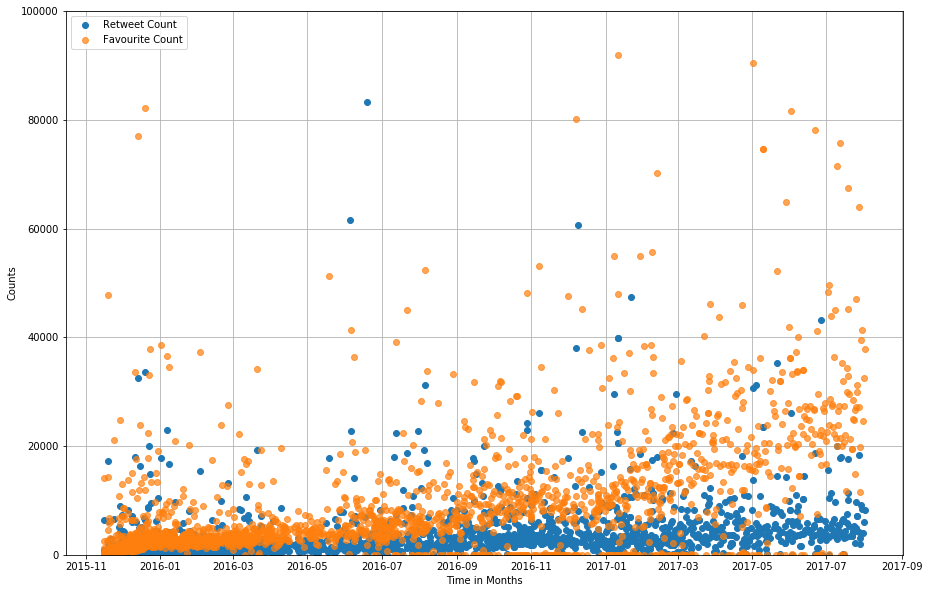

In [41]:
fig = plt.figure(figsize=(15,10))

plt.plot_date(dates,tam_df_rev['retweet_count'])
plt.plot_date(dates,tam_df_rev['favorite_count'],alpha=0.7)
plt.xlabel('Time in Months')
plt.ylabel('Counts')
plt.gca().legend(('Retweet Count','Favourite Count'))
plt.gca().set_ylim([0,100000])
plt.grid(b=None, which='major', axis='both')

It seems, that the Favourite Count will increase at all with the time. To proof this observation I will calculate the __Linear Regression__ for both, the Favourite Count and the Retweet Count over the time to verify it.  

#### Code for Linear Regression and updated Visualisation

In [54]:
from scipy import stats

fav_slope, fav_intercept, r_value, p_value, std_err = stats.linregress(dates, tam_df_rev['favorite_count'])
ret_slope, ret_intercept, r_value, p_value, std_err = stats.linregress(dates, tam_df_rev['retweet_count'])

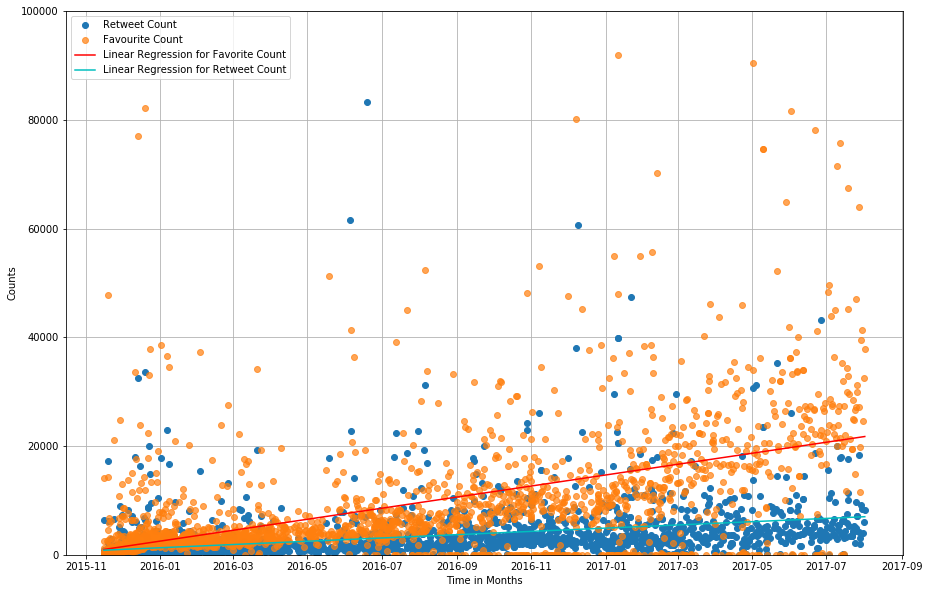

In [62]:
fig = plt.figure(figsize=(15,10))

plt.plot_date(dates,tam_df_rev['retweet_count'])
plt.plot_date(dates,tam_df_rev['favorite_count'],alpha=0.7)
plt.plot_date(dates,dates*fav_slope+fav_intercept,'r-')
plt.plot_date(dates,dates*ret_slope+ret_intercept,'c-')
plt.xlabel('Time in Months')
plt.ylabel('Counts')
plt.gca().legend(('Retweet Count','Favourite Count','Linear Regression for Favorite Count','Linear Regression for Retweet Count'))
plt.gca().set_ylim([0,100000])
plt.grid(b=None, which='major', axis='both')

Actually, there is an obvious increase for the Favourite account over time. It seems, that a quadratic polynomial regression would match the course of the dots in a  slightly more accurate way but I think it's goood enough to verify the first observation. 

#### Evaluation
To explain the difference in increase we can ask for our own behaviour on social media like Twitter. The effort of will to like or favourise a post is much smaller than retweeting it and reveal a stronger commitment, i.e. a stronger opinion to the content of the post.

__Important:__ Overall we have to take into consideration a specific factor to correct the rating of "WeRateDogs" posts based on Retweet Counts and Favourite Counts if observing the whole timeline.